In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_convolution
import random
import math
import seaborn
from  matplotlib import pyplot
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.nn as nn
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [2]:
window_size = 0.15

In [3]:
df_yolo = pd.read_csv('/home/rliu/github/defect_classifier/yolo2_dm/results/test_yolo.csv', sep=' ')
df_truth = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" ")
df_MMN = pd.read_csv('/home/rliu/github/defect_classifier/yolo2_dm/results/test_MMN.csv', sep=' ')

In [4]:
columns = ['image_index','class', 'x', 'y']
df_yolo_points = pd.DataFrame(index=np.arange(len(df_yolo)), columns=columns)
df_yolo_points['image_index'] = df_yolo['image_index']
df_yolo_points['class'] = df_yolo['class']
df_yolo_points['x'] = (df_yolo['x1'] + df_yolo['x2'])/2
df_yolo_points['y'] = (df_yolo['y1'] + df_yolo['y2'])/2
for index, row in df_yolo.iterrows():
    if (row['class'] == 0) & (row.confidence<0.24):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 1) & (row.confidence<0.1):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 2) & (row.confidence<0.12):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 3) & (row.confidence<0.06):
        df_yolo_points = df_yolo_points.drop(index)

In [5]:
df_MMN = df_MMN.drop(columns = ['confidence'])
new_order = [1,0,2,3]
df_MMN = df_MMN[df_MMN.columns[new_order]]

In [6]:
df_yolo_points = df_yolo_points.replace({'class':2},0)

In [7]:
df_yolo_points.to_csv('/home/rliu/github/defect_classifier/results/yolo_1-19-18.csv', sep=' ', index=False, header=False)

In [8]:
df_truth.image_index.unique()

array([6501, 6502, 6503, ..., 8898, 8899, 8900])

In [20]:
valid = np.concatenate((np.arange(6501,7001),np.arange(8201,8234),np.arange(8801,8834)))
test = np.concatenate((np.arange(7001,8001),np.arange(8234,8301),np.arange(8834,8901)))

In [21]:
columns = ['image_index','class', 'x', 'y']
df_results = pd.DataFrame(index=np.arange(0), columns=columns)
# df_truth = df_truth[(df_truth['image_index'] <= 8900) & (df_truth['image_index'] >= 8801)]
# df_test = df_truth.loc[df_truth['image_index'].isin(np.arange(6501,6601))]
for i in test:# detecting local maxima in confidence map to find defects
    columns = ['image_index','class', 'x', 'y']
    df_img = pd.DataFrame(index=np.arange(0), columns=columns)
    
    arr_pos = np.load('/home/rliu/defect_classifier/convolution_test/pos/%06.0f.npy' % i)
    arr_neg = np.load('/home/rliu/defect_classifier/convolution_test/neg/%06.0f.npy' % i)
    arr_pos_o = np.load('/home/rliu/defect_classifier/convolution_test/pos_o/%06.0f.npy' % i)
    arr_nuc = np.load('/home/rliu/defect_classifier/convolution_test/nuc/%06.0f.npy' % i)
    
    coord_pos = peak_local_max(arr_pos, min_distance=15, threshold_abs=0.983, threshold_rel = 0.9).astype(float)
    coord_neg = peak_local_max(arr_neg, min_distance=8, threshold_abs=0.988, threshold_rel = 0.9).astype(float)
    coord_pos_o = peak_local_max(arr_pos_o, min_distance=12, threshold_abs=0.97, threshold_rel = 0.9).astype(float)
    coord_nuc = peak_local_max(arr_nuc, min_distance=12, threshold_abs=0.93, threshold_rel = 0.9).astype(float)
    
    coord_pos[:,0], coord_pos[:,1] = coord_pos[:,0]/150.0, coord_pos[:,1]/150.0
    coord_neg[:,0], coord_neg[:,1] = coord_neg[:,0]/150.0, coord_neg[:,1]/150.0
    coord_pos_o[:,0], coord_pos_o[:,1] = coord_pos_o[:,0]/150.0, coord_pos_o[:,1]/150.0
    coord_nuc[:,0], coord_nuc[:,1] = coord_nuc[:,0]/150.0, coord_nuc[:,1]/150.0
    
    df_pos = pd.DataFrame(index=np.arange(coord_pos.shape[0]), columns=columns)
    df_neg = pd.DataFrame(index=np.arange(coord_neg.shape[0]), columns=columns)
    df_pos_o = pd.DataFrame(index=np.arange(coord_pos_o.shape[0]), columns=columns)
    df_nuc = pd.DataFrame(index=np.arange(coord_nuc.shape[0]), columns=columns)
    
    df_pos['class'] = 0
    df_neg['class'] = 1
    df_pos_o['class'] = 2
    df_nuc['class'] = 3
    
    df_pos['x'], df_pos['y'] = coord_pos[:,1], 1 - coord_pos[:,0]
    df_neg['x'], df_neg['y'] = coord_neg[:,1], 1 - coord_neg[:,0]
    df_pos_o['x'], df_pos_o['y'] = coord_pos_o[:,1], 1 - coord_pos_o[:,0]
    df_nuc['x'], df_nuc['y'] = coord_nuc[:,1], 1 - coord_nuc[:,0]
    
    df_img = df_img.append(df_pos, ignore_index=True)
    df_img = df_img.append(df_neg, ignore_index=True)
    df_img = df_img.append(df_pos_o, ignore_index=True)
    df_img = df_img.append(df_nuc, ignore_index=True)
    
    df_img['image_index'] = i
    df_results = df_results.append(df_img, ignore_index=True)

In [22]:
df_results_yolo = checkYolo(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo.replace({'class':2},0), df_results = df_results.replace({'class':2},0))
df_results_yolo = putBackYOLO(window_size = 0.20, conf_thres_pos = 0.7, conf_thres_neg = 0.8, conf_thres_nuc = 1, conf_thres_pos_o = 0.9, df_yolo = df_yolo, df_results = df_results_yolo.replace({'class':2},0))
df_results_yolo = df_results_yolo.replace({'class':2},0)

In [24]:
# df_results_yolo.to_csv('/home/rliu/github/defect_classifier/results/yoloSlide_1-19-18.csv', sep=' ', index=False, header=False)

In [105]:
# df_results_yolo = checkYolo(conf_thres_pos = 0.001, conf_thres_neg = 0.01, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo, df_results = df_results)

In [106]:
# df_results_yolo = checkYolo_checkAllBoxes(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo.replace({'class':2},0), df_results = df_results.replace({'class':2},0))

In [23]:
df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)

In [39]:
# df = compareLabels(df_results_yolo, df_truth, window_size=0.16)

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

   truth_tot  truth_pos  truth_neg  truth_pos_o  truth_nuc  correct_tot  \
0       5995       3769       1610            0        616         4187   

   correct_pos  correct_neg  correct_pos_o  correct_nuc  pred_tot  pred_pos  \
0         3071          893              0          223      5646      3694   

   pred_neg  pred_pos_o  pred_nuc     dis_pos     dis_neg  dis_pos_o  \
0      1510           0       442  217.605055  336.508389          0   

      dis_nuc  dis_pos_c  dis_neg_c  dis_pos_o_c  dis_nuc_c  
0  306.957383  57.755701   8.610113            0   3.264369  


In [25]:
df_truth = df_truth.loc[df_truth['image_index'].isin(test)]
df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)
precision_tot = df.loc[0,'correct_tot'] / df.loc[0,'pred_tot']
precision_pos = df.loc[0,'correct_pos'] / df.loc[0,'pred_pos']
precision_neg = df.loc[0,'correct_neg'] / df.loc[0,'pred_neg']
precision_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'pred_pos_o']
precision_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'pred_nuc']

recall_tot = df.loc[0,'correct_tot'] / df.loc[0,'truth_tot']
recall_pos = df.loc[0,'correct_pos'] / df.loc[0,'truth_pos']
recall_neg = df.loc[0,'correct_neg'] / df.loc[0,'truth_neg']
recall_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'truth_pos_o']
recall_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'truth_nuc']

accuracy_tot = 2*(precision_tot*recall_tot)/(precision_tot+recall_tot)
accuracy_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
accuracy_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
accuracy_pos_o = 2*(precision_pos_o*recall_pos_o)/(precision_pos_o+recall_pos_o)
accuracy_nuc = 2*(precision_nuc*recall_nuc)/(precision_nuc+recall_nuc)

precision_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'pred_pos']+df.loc[0,'pred_neg'])
recall_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'truth_pos']+df.loc[0,'truth_neg'])
accuracy_pn = 2*(precision_pn*recall_pn)/(precision_pn+recall_pn)

dis_pos_c = df.loc[0,'dis_pos_c'] / df.loc[0,'correct_pos']
dis_neg_c = df.loc[0,'dis_neg_c'] / df.loc[0,'correct_neg']
dis_pos_o_c = df.loc[0,'dis_pos_o_c'] / df.loc[0,'correct_pos_o']
dis_nuc_c = df.loc[0,'dis_nuc_c'] / df.loc[0,'correct_nuc']



print('precision_tot =', precision_tot)
print('precision_pos =', precision_pos)
print('precision_neg =', precision_neg)
print('precision_pos_o =', precision_pos_o)
print('precision_nuc =', precision_nuc)
print('precision_pn =', precision_pn)
print('\n')
print('recall_tot =', recall_tot)
print('recall_pos =', recall_pos)
print('recall_neg =', recall_neg)
print('recall_pos_o =', recall_pos_o)
print('recall_nuc =', recall_nuc)
print('recall_pn =', recall_pn)
print('\n')
print('accuracy_tot =', accuracy_tot)
print('accuracy_pos =', accuracy_pos)
print('accuracy_neg =', accuracy_neg)
print('accuracy_pos_o =', accuracy_pos_o)
print('accuracy_nuc =', accuracy_nuc)
print('\n')
print('dis_pos =', dis_pos_c)
print('dis_neg =', dis_neg_c)
print('dis_pos_o =', dis_pos_o_c)
print('dis_nuc =', dis_nuc_c)
print('\n')
print('accuracy_pn =', accuracy_pn)



precision_tot = 0.7415869642224584
precision_pos = 0.831348132106118
precision_neg = 0.5913907284768212
precision_pos_o = nan
precision_nuc = 0.504524886877828
precision_pn = 0.7617217524980784


recall_tot = 0.6984153461217681
recall_pos = 0.8148049880604935
recall_neg = 0.5546583850931677
recall_pos_o = nan
recall_nuc = 0.362012987012987
recall_pn = 0.736939951663878


accuracy_tot = 0.7193540073876815
accuracy_pos = 0.8229934342757603
accuracy_neg = 0.5724358974358974
accuracy_pos_o = nan
accuracy_nuc = 0.42155009451795844


dis_pos = 0.01880680608132993
dis_neg = 0.00964178354107062
dis_pos_o = nan
dis_nuc = 0.014638428047556782


accuracy_pn = 0.7491259567230463


/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


In [28]:
(3071*0.0188+893*0.00964)/(3071+893)

0.016736458123107974

In [39]:
df_yolo_points = df_yolo_points.loc[df_yolo_points['image_index'].isin(test)]
df_truth = df_truth.loc[df_truth['image_index'].isin(test)]

In [15]:
df_yolo_points

,image_index,class,x,y
0,6501.0,0.0,0.452002,0.412364
1,6501.0,0.0,0.250961,0.623060
2,6501.0,0.0,0.486278,0.782313
3,6501.0,0.0,0.726051,0.243703
5,6501.0,3.0,0.571316,0.088327
6,6501.0,1.0,0.111765,0.603808
11,6502.0,1.0,0.140751,0.646682
16,6502.0,3.0,0.573203,0.088042
19,6502.0,0.0,0.725912,0.245492
20,6502.0,0.0,0.487924,0.781787


In [13]:
columns = ['image_index','class', 'x', 'y']
df_yolo_points = pd.DataFrame(index=np.arange(len(df_yolo)), columns=columns)
df_yolo_points['image_index'] = df_yolo['image_index']
df_yolo_points['class'] = df_yolo['class']
df_yolo_points['x'] = (df_yolo['x1'] + df_yolo['x2'])/2
df_yolo_points['y'] = (df_yolo['y1'] + df_yolo['y2'])/2
for index, row in df_yolo.iterrows():
    if (row['class'] == 0) & (row.confidence<0.24):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 1) & (row.confidence<0.1):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 2) & (row.confidence<0.12):
        df_yolo_points = df_yolo_points.drop(index)
    if (row['class'] == 3) & (row.confidence<0.06):
        df_yolo_points = df_yolo_points.drop(index)
df = compareLabels(df_yolo_points, df_truth.replace({'class':2},0), window_size=window_size)
precision_tot = df.loc[0,'correct_tot'] / df.loc[0,'pred_tot']
precision_pos = df.loc[0,'correct_pos'] / df.loc[0,'pred_pos']
precision_neg = df.loc[0,'correct_neg'] / df.loc[0,'pred_neg']
precision_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'pred_pos_o']
precision_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'pred_nuc']

recall_tot = df.loc[0,'correct_tot'] / df.loc[0,'truth_tot']
recall_pos = df.loc[0,'correct_pos'] / df.loc[0,'truth_pos']
recall_neg = df.loc[0,'correct_neg'] / df.loc[0,'truth_neg']
recall_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'truth_pos_o']
recall_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'truth_nuc']

accuracy_tot = 2*(precision_tot*recall_tot)/(precision_tot+recall_tot)
accuracy_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
accuracy_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
accuracy_pos_o = 2*(precision_pos_o*recall_pos_o)/(precision_pos_o+recall_pos_o)
accuracy_nuc = 2*(precision_nuc*recall_nuc)/(precision_nuc+recall_nuc)

precision_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'pred_pos']+df.loc[0,'pred_neg'])
recall_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'truth_pos']+df.loc[0,'truth_neg'])
accuracy_pn = 2*(precision_pn*recall_pn)/(precision_pn+recall_pn)

dis_pos_c = df.loc[0,'dis_pos_c'] / df.loc[0,'correct_pos']
dis_neg_c = df.loc[0,'dis_neg_c'] / df.loc[0,'correct_neg']
dis_pos_o_c = df.loc[0,'dis_pos_o_c'] / df.loc[0,'correct_pos_o']
dis_nuc_c = df.loc[0,'dis_nuc_c'] / df.loc[0,'correct_nuc']


print('precision_tot =', precision_tot)
print('precision_pos =', precision_pos)
print('precision_neg =', precision_neg)
print('precision_pos_o =', precision_pos_o)
print('precision_nuc =', precision_nuc)
print('\n')
print('recall_tot =', recall_tot)
print('recall_pos =', recall_pos)
print('recall_neg =', recall_neg)
print('recall_pos_o =', recall_pos_o)
print('recall_nuc =', recall_nuc)
print('\n')
print('accuracy_tot =', accuracy_tot)
print('accuracy_pos =', accuracy_pos)
print('accuracy_neg =', accuracy_neg)
print('accuracy_pos_o =', accuracy_pos_o)
print('accuracy_nuc =', accuracy_nuc)
print('\n')
print('dis_pos =', dis_pos_c)
print('dis_neg =', dis_neg_c)
print('dis_pos_o =', dis_pos_o_c)
print('dis_nuc =', dis_nuc_c)

print('\n')

print('precision_pn =', precision_pn)
print('recall_pn =', recall_pn)
print('accuracy_pn =', accuracy_pn)

precision_tot = 0.5709507883420927
precision_pos = 0.8724651844612753
precision_neg = 0.4022155943757989
precision_pos_o = 0.0
precision_nuc = 0.3538050734312417


recall_tot = 0.5361749859786876
recall_pos = 0.6278129395218003
recall_neg = 0.39647207055858885
recall_pos_o = nan
recall_nuc = 0.3132387706855792


accuracy_tot = 0.5530167177647944
accuracy_pos = 0.7301911869951948
accuracy_neg = 0.3993231810490694
accuracy_pos_o = nan
accuracy_nuc = 0.3322884012539185


dis_pos = 0.036515996409425405
dis_neg = 0.034912777116851555
dis_pos_o = nan
dis_nuc = 0.039456224022915494


precision_pn = 0.7010869565217391
recall_pn = 0.5595488908167059
accuracy_pn = 0.6223723206285754


/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


In [1]:
(4457*0.0368+944*0.0349)/(4457+944)

0.03646791334937974

In [55]:
df_yolo_points

,image_index,class,x,y
0,6501.0,0.0,0.452002,0.412364
1,6501.0,0.0,0.250961,0.623060
2,6501.0,0.0,0.486278,0.782313
3,6501.0,0.0,0.726051,0.243703
5,6501.0,3.0,0.571316,0.088327
6,6501.0,1.0,0.111765,0.603808
11,6502.0,1.0,0.140751,0.646682
16,6502.0,3.0,0.573203,0.088042
19,6502.0,0.0,0.725912,0.245492
20,6502.0,0.0,0.487924,0.781787


In [41]:
df_truth = df_truth.loc[df_truth['image_index'].isin(test)]
df_MMN = df_MMN.loc[df_MMN['image_index'].isin(test)]

In [18]:
# MMN
df = compareLabels(df_MMN, df_truth.replace({'class':2},0), window_size=window_size)
precision_tot = df.loc[0,'correct_tot'] / df.loc[0,'pred_tot']
precision_pos = df.loc[0,'correct_pos'] / df.loc[0,'pred_pos']
precision_neg = df.loc[0,'correct_neg'] / df.loc[0,'pred_neg']
precision_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'pred_pos_o']
precision_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'pred_nuc']

recall_tot = df.loc[0,'correct_tot'] / df.loc[0,'truth_tot']
recall_pos = df.loc[0,'correct_pos'] / df.loc[0,'truth_pos']
recall_neg = df.loc[0,'correct_neg'] / df.loc[0,'truth_neg']
recall_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'truth_pos_o']
recall_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'truth_nuc']

accuracy_tot = 2*(precision_tot*recall_tot)/(precision_tot+recall_tot)
accuracy_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
accuracy_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
accuracy_pos_o = 2*(precision_pos_o*recall_pos_o)/(precision_pos_o+recall_pos_o)
accuracy_nuc = 2*(precision_nuc*recall_nuc)/(precision_nuc+recall_nuc)

precision_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'pred_pos']+df.loc[0,'pred_neg'])
recall_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'truth_pos']+df.loc[0,'truth_neg'])
accuracy_pn = 2*(precision_pn*recall_pn)/(precision_pn+recall_pn)

dis_pos_c = df.loc[0,'dis_pos_c'] / df.loc[0,'correct_pos']
dis_neg_c = df.loc[0,'dis_neg_c'] / df.loc[0,'correct_neg']
dis_pos_o_c = df.loc[0,'dis_pos_o_c'] / df.loc[0,'correct_pos_o']
dis_nuc_c = df.loc[0,'dis_nuc_c'] / df.loc[0,'correct_nuc']


print('precision_tot =', precision_tot)
print('precision_pos =', precision_pos)
print('precision_neg =', precision_neg)
print('precision_pos_o =', precision_pos_o)
print('precision_nuc =', precision_nuc)
print('\n')
print('recall_tot =', recall_tot)
print('recall_pos =', recall_pos)
print('recall_neg =', recall_neg)
print('recall_pos_o =', recall_pos_o)
print('recall_nuc =', recall_nuc)
print('\n')
print('accuracy_tot =', accuracy_tot)
print('accuracy_pos =', accuracy_pos)
print('accuracy_neg =', accuracy_neg)
print('accuracy_pos_o =', accuracy_pos_o)
print('accuracy_nuc =', accuracy_nuc)
print('\n')
print('dis_pos =', dis_pos_c)
print('dis_neg =', dis_neg_c)
print('dis_pos_o =', dis_pos_o_c)
print('dis_nuc =', dis_nuc_c)
print('\n')

print('precision_pn =', precision_pn)
print('recall_pn =', recall_pn)
print('accuracy_pn =', accuracy_pn)

precision_tot = 0.5103948549207299
precision_pos = 0.6007194244604317
precision_neg = 0.36069157392686807
precision_pos_o = nan
precision_nuc = nan


recall_tot = 0.7655636567582725
recall_pos = 0.880801687763713
recall_neg = 0.7622847543049139
recall_pos_o = nan
recall_nuc = 0.0


accuracy_tot = 0.6124646655000673
accuracy_pos = 0.7142857142857143
accuracy_neg = 0.4896802913800082
accuracy_pos_o = nan
accuracy_nuc = nan


dis_pos = 0.029023058169392487
dis_neg = 0.02761369177521145
dis_pos_o = nan
dis_nuc = nan


precision_pn = 0.5103948549207299
recall_pn = 0.8458297186764159
accuracy_pn = 0.6366307541625856


/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


In [3]:
(5005*0.029+1815*0.0276)/(5005+1815)

0.02862741935483871

In [8]:
df_results = df_yolo_points

In [9]:
def compareLabels(df_results, df_truth, window_size=0.20):
    truth_tot = 0
    correct_tot = 0
    pred_tot = 0

    truth_pos = 0
    correct_pos = 0
    pred_pos = 0

    truth_neg = 0
    correct_neg = 0
    pred_neg = 0

    truth_pos_o = 0
    correct_pos_o = 0
    pred_pos_o = 0

    truth_nuc = 0
    correct_nuc = 0
    pred_nuc = 0

    dis_pos = 0
    dis_neg = 0
    dis_pos_o = 0
    dis_nuc = 0

    dis_pos_c = 0
    dis_neg_c = 0
    dis_pos_o_c = 0
    dis_nuc_c = 0


    for i in df_truth['image_index'].unique():
        df_truth_img = df_truth[df_truth['image_index'] == i]
        df_results_img = df_results[df_results['image_index'] == i]
        truth_tot += len(df_truth_img.index) # get total truth number
        pred_tot += len(df_results_img.index) # get total prediction number

        # seperate truth labels
        df_truth_pos = df_truth_img[df_truth_img['class']==0]
        truth_pos += len(df_truth_pos.index)
        df_truth_neg = df_truth_img[df_truth_img['class']==1]
        truth_neg += len(df_truth_neg.index)
        df_truth_pos_o = df_truth_img[df_truth_img['class']==2]
        truth_pos_o += len(df_truth_pos_o.index)
        df_truth_nuc = df_truth_img[df_truth_img['class']==3]
        truth_nuc += len(df_truth_nuc.index)

        # seperate prediction labels
        df_results_pos = df_results_img[df_results_img['class']==0]
        pred_pos += len(df_results_pos.index)
        df_results_neg = df_results_img[df_results_img['class']==1]
        pred_neg += len(df_results_neg.index)
        df_results_pos_o = df_results_img[df_results_img['class']==2]
        pred_pos_o += len(df_results_pos_o.index)
        df_results_nuc = df_results_img[df_results_img['class']==3]
        pred_nuc += len(df_results_nuc.index)

        for index_t, row_t in df_truth_pos.iterrows():
            mindis = 1
            xt, yt = row_t.x, row_t.y
            for index_p, row_p in df_results_pos.iterrows():
                xp, yp = row_p.x, row_p.y
                dis = np.linalg.norm(np.array([xt,yt])-np.array([xp,yp]))
                if dis < mindis:
                    mindis = dis
            if mindis < window_size/2:
                correct_pos += 1 # increment correct number if minimum distance to a prediction is smaller than window_size
                dis_pos_c += mindis
            dis_pos += mindis

        for index_t, row_t in df_truth_neg.iterrows():
            mindis = 1
            xt, yt = row_t.x, row_t.y
            for index_p, row_p in df_results_neg.iterrows():
                xp, yp = row_p.x, row_p.y
                dis = np.linalg.norm(np.array([xt,yt])-np.array([xp,yp]))
                if dis < mindis:
                    mindis = dis
            if mindis < window_size/2:
                correct_neg += 1
                dis_neg_c += mindis
            dis_neg += mindis

        for index_t, row_t in df_truth_pos_o.iterrows():
            mindis = 1
            xt, yt = row_t.x, row_t.y
            for index_p, row_p in df_results_pos_o.iterrows():
                xp, yp = row_p.x, row_p.y
                dis = np.linalg.norm(np.array([xt,yt])-np.array([xp,yp]))
                if dis < mindis:
                    mindis = dis
            if mindis < window_size/2:
                correct_pos_o += 1
                dis_pos_o_c += mindis
            dis_pos_o += mindis

        for index_t, row_t in df_truth_nuc.iterrows():
            mindis = 1
            xt, yt = row_t.x, row_t.y
            for index_p, row_p in df_results_nuc.iterrows():
                xp, yp = row_p.x, row_p.y
                dis = np.linalg.norm(np.array([xt,yt])-np.array([xp,yp]))
                if dis < mindis:
                    mindis = dis
            if mindis < window_size/2:
                correct_nuc += 1
                dis_nuc_c += mindis
            dis_nuc += mindis
    correct_tot = correct_pos + correct_neg + correct_pos_o + correct_nuc
    columns = ['truth_tot', 'truth_pos', 'truth_neg', 'truth_pos_o', 'truth_nuc',
               'correct_tot', 'correct_pos', 'correct_neg', 'correct_pos_o', 'correct_nuc', 
               'pred_tot', 'pred_pos', 'pred_neg', 'pred_pos_o', 'pred_nuc',
               'dis_pos', 'dis_neg', 'dis_pos_o', 'dis_nuc', 
               'dis_pos_c', 'dis_neg_c', 'dis_pos_o_c', 'dis_nuc_c'] 
    df = pd.DataFrame(index=np.arange(1), columns=columns)
    df['truth_tot']=truth_tot
    df['correct_tot']=correct_tot
    df['pred_tot']=pred_tot

    df['truth_pos']=truth_pos
    df['correct_pos']=correct_pos
    df['pred_pos']=pred_pos

    df['truth_neg']=truth_neg
    df['correct_neg']=correct_neg
    df['pred_neg']=pred_neg

    df['truth_pos_o']=truth_pos_o
    df['correct_pos_o']=correct_pos_o
    df['pred_pos_o']=pred_pos_o

    df['truth_nuc']=truth_nuc
    df['correct_nuc']=correct_nuc
    df['pred_nuc']=pred_nuc

    df['dis_pos']=dis_pos
    df['dis_neg']=dis_neg
    df['dis_pos_o']=dis_pos_o
    df['dis_nuc']=dis_nuc

    df['dis_pos_c']=dis_pos_c
    df['dis_neg_c']=dis_neg_c
    df['dis_pos_o_c']=dis_pos_o_c
    df['dis_nuc_c']=dis_nuc_c
    return df

In [10]:
def checkYolo(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo, df_results = df_results):
    columns = ['image_index','class', 'x', 'y']
    df_results_tot = pd.DataFrame(index=np.arange(0), columns=columns)
    for i in df_yolo.image_index.unique():
        df_yolo_pos = df_yolo[(df_yolo['class']==0) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos)]
        df_yolo_neg = df_yolo[(df_yolo['class']==1) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_neg)]
        df_yolo_pos_o = df_yolo[(df_yolo['class']==2) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos_o)]
        df_yolo_nuc = df_yolo[(df_yolo['class']==3) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_nuc)]
#         df_yolo_pos = df_yolo_pos.append(df_yolo_pos_o, ignore_index=True)
        
        df_results_pos = df_results[(df_results['class']==0) & (df_results['image_index']==i)]
        df_results_neg = df_results[(df_results['class']==1) & (df_results['image_index']==i)]
        df_results_pos_o = df_results[(df_results['class']==2) & (df_results['image_index']==i)]
        df_results_nuc = df_results[(df_results['class']==3) & (df_results['image_index']==i)]
#         df_results_pos = df_results_pos.append(df_results_pos_o, ignore_index=True)
        
        for index_p, row_p in df_results_pos.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_pos.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_pos = df_results_pos.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_pos, ignore_index=True)
        
        for index_p, row_p in df_results_neg.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_neg.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_neg = df_results_neg.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_neg, ignore_index=True)
        
        for index_p, row_p in df_results_pos_o.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_pos_o.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_pos_o = df_results_pos_o.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_pos_o, ignore_index=True)
        
        for index_p, row_p in df_results_nuc.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_nuc.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_nuc = df_results_nuc.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_nuc, ignore_index=True)
    return df_results_tot

In [11]:
def putBackYOLO(df_results = df_results, df_yolo = df_yolo, conf_thres_pos = 0.24, conf_thres_neg = 0.1, conf_thres_nuc = 0.12, conf_thres_pos_o = 0.06, window_size = window_size):
    columns = ['image_index','class', 'x', 'y']
    df_results_tot = pd.DataFrame(index=np.arange(0), columns=columns)
    for i in df_results.image_index.unique():
        df_yolo_pos = df_yolo[(df_yolo['class']==0) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos)]
        df_yolo_neg = df_yolo[(df_yolo['class']==1) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_neg)]
        df_yolo_pos_o = df_yolo[(df_yolo['class']==2) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos_o)]
        df_yolo_nuc = df_yolo[(df_yolo['class']==3) & (df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_nuc)]
        
        df_results_pos = df_results[(df_results['class']==0) & (df_results['image_index']==i)]
        df_results_neg = df_results[(df_results['class']==1) & (df_results['image_index']==i)]
        df_results_pos_o = df_results[(df_results['class']==2) & (df_results['image_index']==i)]
        df_results_nuc = df_results[(df_results['class']==3) & (df_results['image_index']==i)]
        
        for index_y, row_y in df_yolo_pos.iterrows():
            putBack = True
            xy,yy = (row_y.x1+row_y.x2)/2, (row_y.y1+row_y.y2)/2
            for index_p, row_p in df_results_pos.iterrows():
                xp, yp = row_p.x, row_p.y
                if np.linalg.norm(np.array([xy,yy])-np.array([xp,yp])) <= window_size/2:
                    putBack = False
            if putBack:
                columns = ['image_index','class', 'x', 'y']
                df = pd.DataFrame(index=np.arange(1), columns=columns)
                df.image_index = i
                df['class'] = 0
                df.x = xy
                df.y = yy
                df_results_pos = df_results_pos.append(df, ignore_index=True)
        df_results_tot = df_results_tot.append(df_results_pos, ignore_index=True)
        
        for index_y, row_y in df_yolo_neg.iterrows():
            putBack = True
            xy,yy = (row_y.x1+row_y.x2)/2, (row_y.y1+row_y.y2)/2
            for index_p, row_p in df_results_neg.iterrows():
                xp, yp = row_p.x, row_p.y
                if np.linalg.norm(np.array([xy,yy])-np.array([xp,yp])) <= window_size/2:
                    putBack = False
            if putBack:
                columns = ['image_index','class', 'x', 'y']
                df = pd.DataFrame(index=np.arange(1), columns=columns)
                df.image_index = i
                df['class'] = 1
                df.x = xy
                df.y = yy
                df_results_neg = df_results_neg.append(df, ignore_index=True)
        df_results_tot = df_results_tot.append(df_results_neg, ignore_index=True)
        
        for index_y, row_y in df_yolo_pos_o.iterrows():
            putBack = True
            xy,yy = (row_y.x1+row_y.x2)/2, (row_y.y1+row_y.y2)/2
            for index_p, row_p in df_results_pos.iterrows():
                xp, yp = row_p.x, row_p.y
                if np.linalg.norm(np.array([xy,yy])-np.array([xp,yp])) <= window_size/2:
                    putBack = False
            if putBack:
                columns = ['image_index','class', 'x', 'y']
                df = pd.DataFrame(index=np.arange(1), columns=columns)
                df.image_index = i
                df['class'] = 2
                df.x = xy
                df.y = yy
                df_results_pos_o = df_results_pos_o.append(df, ignore_index=True)
        df_results_tot = df_results_tot.append(df_results_pos_o, ignore_index=True)
        
        for index_y, row_y in df_yolo_nuc.iterrows():
            putBack = True
            xy,yy = (row_y.x1+row_y.x2)/2, (row_y.y1+row_y.y2)/2
            for index_p, row_p in df_results_nuc.iterrows():
                xp, yp = row_p.x, row_p.y
                if np.linalg.norm(np.array([xy,yy])-np.array([xp,yp])) <= window_size/2:
                    putBack = False
            if putBack:
                columns = ['image_index','class', 'x', 'y']
                df = pd.DataFrame(index=np.arange(1), columns=columns)
                df.image_index = i
                df['class'] = 3
                df.x = xy
                df.y = yy
                df_results_nuc = df_results_nuc.append(df, ignore_index=True)
        df_results_tot = df_results_tot.append(df_results_nuc, ignore_index=True)
    return df_results_tot

In [12]:
def checkYolo_checkAllBoxes(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo, df_results = df_results):
    columns = ['image_index','class', 'x', 'y']
    df_results_tot = pd.DataFrame(index=np.arange(0), columns=columns)
    for i in df_yolo.image_index.unique():
        df_yolo_pos = df_yolo[(df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos)]
        df_yolo_neg = df_yolo[(df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_neg)]
        df_yolo_pos_o = df_yolo[(df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_pos_o)]
        df_yolo_nuc = df_yolo[(df_yolo['image_index']==i) & (df_yolo['confidence']>conf_thres_nuc)]
        
        df_results_pos = df_results[(df_results['class']==0) & (df_results['image_index']==i)]
        df_results_neg = df_results[(df_results['class']==1) & (df_results['image_index']==i)]
        df_results_pos_o = df_results[(df_results['class']==2) & (df_results['image_index']==i)]
        df_results_nuc = df_results[(df_results['class']==3) & (df_results['image_index']==i)]
        
        for index_p, row_p in df_results_pos.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_pos.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_pos = df_results_pos.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_pos, ignore_index=True)
        
        for index_p, row_p in df_results_neg.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_neg.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_neg = df_results_neg.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_neg, ignore_index=True)
        
        for index_p, row_p in df_results_pos_o.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_pos_o.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_pos_o = df_results_pos_o.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_pos_o, ignore_index=True)
        
        for index_p, row_p in df_results_nuc.iterrows():
            drop = True
            x,y = row_p.x, row_p.y
            for index_y, row_y in df_yolo_nuc.iterrows():
                x1,x2,y1,y2 = row_y.x1,row_y.x2,row_y.y1,row_y.y2
                if (x1 <= x <= x2) & (y1 <= y <= y2):
                    drop = False
            if drop:
                df_results_nuc = df_results_nuc.drop(index_p)
        df_results_tot = df_results_tot.append(df_results_nuc, ignore_index=True)
    return df_results_tot

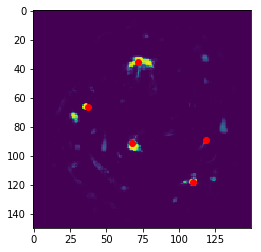

In [176]:
arr = np.load('/home/rliu/defect_classifier/convolution_test/pos/006501.npy')
coordinates = peak_local_max(arr, min_distance=20, threshold_abs=0.5, threshold_rel = 0.5)
plt.imshow(arr)
y = coordinates[:,0]
x = coordinates[:,1]
plt.scatter(x,y, c='r')

In [15]:
columns = ['image_index','class', 'x', 'y']
df_results = pd.DataFrame(index=np.arange(0), columns=columns)
df_truth = df_truth[(df_truth['image_index'] <= 7000) & (df_truth['image_index'] >= 7500)]
df_test = df_truth.loc[df_truth['image_index'].isin(np.arange(6501,6601))]
for i in np.arange(7000,7500): # detecting local maxima in confidence map to find defects
    columns = ['image_index','class', 'x', 'y']
    df_img = pd.DataFrame(index=np.arange(0), columns=columns)
    
    arr_pos = np.load('/home/rliu/defect_classifier/convolution_test/pos/%06.0f.npy' % i)
    arr_neg = np.load('/home/rliu/defect_classifier/convolution_test/neg/%06.0f.npy' % i)
    arr_pos_o = np.load('/home/rliu/defect_classifier/convolution_test/pos_o/%06.0f.npy' % i)
    arr_nuc = np.load('/home/rliu/defect_classifier/convolution_test/nuc/%06.0f.npy' % i)
    
    coord_pos = peak_local_max(arr_pos, min_distance=15, threshold_abs=0.98, threshold_rel = 0.9).astype(float)
    coord_neg = peak_local_max(arr_neg, min_distance=8, threshold_abs=0.985, threshold_rel = 0.9).astype(float)
    coord_pos_o = peak_local_max(arr_pos_o, min_distance=12, threshold_abs=0.96, threshold_rel = 0.9).astype(float)
    coord_nuc = peak_local_max(arr_nuc, min_distance=12, threshold_abs=0.90, threshold_rel = 0.9).astype(float)
    
    coord_pos[:,0], coord_pos[:,1] = coord_pos[:,0]/150.0, coord_pos[:,1]/150.0
    coord_neg[:,0], coord_neg[:,1] = coord_neg[:,0]/150.0, coord_neg[:,1]/150.0
    coord_pos_o[:,0], coord_pos_o[:,1] = coord_pos_o[:,0]/150.0, coord_pos_o[:,1]/150.0
    coord_nuc[:,0], coord_nuc[:,1] = coord_nuc[:,0]/150.0, coord_nuc[:,1]/150.0
    
    df_pos = pd.DataFrame(index=np.arange(coord_pos.shape[0]), columns=columns)
    df_neg = pd.DataFrame(index=np.arange(coord_neg.shape[0]), columns=columns)
    df_pos_o = pd.DataFrame(index=np.arange(coord_pos_o.shape[0]), columns=columns)
    df_nuc = pd.DataFrame(index=np.arange(coord_nuc.shape[0]), columns=columns)
    
    df_pos['class'] = 0
    df_neg['class'] = 1
    df_pos_o['class'] = 2
    df_nuc['class'] = 3
    
    df_pos['x'], df_pos['y'] = coord_pos[:,1], 1 - coord_pos[:,0]
    df_neg['x'], df_neg['y'] = coord_neg[:,1], 1 - coord_neg[:,0]
    df_pos_o['x'], df_pos_o['y'] = coord_pos_o[:,1], 1 - coord_pos_o[:,0]
    df_nuc['x'], df_nuc['y'] = coord_nuc[:,1], 1 - coord_nuc[:,0]
    
    df_img = df_img.append(df_pos, ignore_index=True)
    df_img = df_img.append(df_neg, ignore_index=True)
    df_img = df_img.append(df_pos_o, ignore_index=True)
    df_img = df_img.append(df_nuc, ignore_index=True)
    
    df_img['image_index'] = i
    df_results = df_results.append(df_img, ignore_index=True)
df_results_yolo = checkYolo(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo.replace({'class':2},0), df_results = df_results.replace({'class':2},0))
df_results_yolo = putBackYOLO(window_size = 0.20, conf_thres_pos = 0.7, conf_thres_neg = 0.8, conf_thres_nuc = 1, conf_thres_pos_o = 0.9, df_yolo = df_yolo, df_results = df_results_yolo.replace({'class':2},0))
df_results_yolo = df_results_yolo.replace({'class':2},0)
df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)
df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)
precision_tot = df.loc[0,'correct_tot'] / df.loc[0,'pred_tot']
precision_pos = df.loc[0,'correct_pos'] / df.loc[0,'pred_pos']
precision_neg = df.loc[0,'correct_neg'] / df.loc[0,'pred_neg']
precision_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'pred_pos_o']
precision_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'pred_nuc']

recall_tot = df.loc[0,'correct_tot'] / df.loc[0,'truth_tot']
recall_pos = df.loc[0,'correct_pos'] / df.loc[0,'truth_pos']
recall_neg = df.loc[0,'correct_neg'] / df.loc[0,'truth_neg']
recall_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'truth_pos_o']
recall_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'truth_nuc']

accuracy_tot = 2*(precision_tot*recall_tot)/(precision_tot+recall_tot)
accuracy_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
accuracy_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
accuracy_pos_o = 2*(precision_pos_o*recall_pos_o)/(precision_pos_o+recall_pos_o)
accuracy_nuc = 2*(precision_nuc*recall_nuc)/(precision_nuc+recall_nuc)

precision_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'pred_pos']+df.loc[0,'pred_neg'])
recall_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'truth_pos']+df.loc[0,'truth_neg'])
accuracy_pn = 2*(precision_pn*recall_pn)/(precision_pn+recall_pn)

dis_pos_c = df.loc[0,'dis_pos_c'] / df.loc[0,'correct_pos']
dis_neg_c = df.loc[0,'dis_neg_c'] / df.loc[0,'correct_neg']
dis_pos_o_c = df.loc[0,'dis_pos_o_c'] / df.loc[0,'correct_pos_o']
dis_nuc_c = df.loc[0,'dis_nuc_c'] / df.loc[0,'correct_nuc']


print('precision_tot =', precision_tot)
print('precision_pos =', precision_pos)
print('precision_neg =', precision_neg)
print('precision_pos_o =', precision_pos_o)
print('precision_nuc =', precision_nuc)
print('\n')
print('recall_tot =', recall_tot)
print('recall_pos =', recall_pos)
print('recall_neg =', recall_neg)
print('recall_pos_o =', recall_pos_o)
print('recall_nuc =', recall_nuc)
print('\n')
print('accuracy_tot =', accuracy_tot)
print('accuracy_pos =', accuracy_pos)
print('accuracy_neg =', accuracy_neg)
print('accuracy_pos_o =', accuracy_pos_o)
print('accuracy_nuc =', accuracy_nuc)
print('\n')
print('dis_pos =', dis_pos_c)
print('dis_neg =', dis_neg_c)
print('dis_pos_o =', dis_pos_o_c)
print('dis_nuc =', dis_nuc_c)
print('\n')
print('accuracy_pn =', accuracy_pn)

precision_tot = 0.7675555555555555
precision_pos = 0.8874576271186441
precision_neg = 0.5947368421052631
precision_pos_o = nan
precision_nuc = 0.3853658536585366


recall_tot = 0.1937184520471116
recall_pos = 0.23013361462728552
recall_neg = 0.14237715245695087
recall_pos_o = nan
recall_nuc = 0.0933806146572104


accuracy_tot = 0.30935960591133005
accuracy_pos = 0.3654893201172693
accuracy_neg = 0.22975262622839715
accuracy_pos_o = nan
accuracy_nuc = 0.15033301617507136


dis_pos = 0.017088514308551534
dis_neg = 0.009108530055212952
dis_pos_o = nan
dis_nuc = 0.007063072546502589


accuracy_pn = 0.3258849120031639


/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars
/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


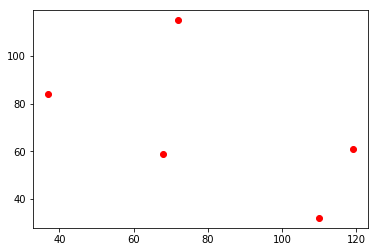

In [182]:
plt.scatter(x,150-y, c='r')